In [85]:
import json
import pandas as pd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Load Raw Data
Initial data processing

1. Load raw data into dataframes for processing and feature identification

In [ ]:
# Load datasets
raw_data_path = "../data/raw"

races = pd.read_csv(f"{raw_data_path}/races.csv")
results = pd.read_csv(f"{raw_data_path}/results.csv")
drivers = pd.read_csv(f"{raw_data_path}/drivers.csv")
constructors = pd.read_csv(f"{raw_data_path}/constructors.csv")
circuits = pd.read_csv(f"{raw_data_path}/circuits.csv")

print("Data loaded successfully!")

print("")
print(f"Races: {races.shape}")
print(f"Results: {results.shape}")
print(f"Drivers: {drivers.shape}")
print(f"Constructors: {constructors.shape}")
print(f"Circuits: {circuits.shape}")


Data loaded successfully!

Races: (1125, 18)
Results: (26759, 18)
Drivers: (861, 9)
Constructors: (212, 5)
Circuits: (77, 9)


## Feature Engineering

Create meaningful features for predicting race winners.

1. It will be more meaningful to consider newer data for predictions than the entire dataset from 1950, a lot have changed since then. 
2. For this exploratory analysis, we will consider data from 2010 onwards.
3. Create the target variables `is_winner` with possibles values `1` if winner, `0` otherwise.
4. Create historical statistics on the win rates for drivers/constructors and cumulative points for the seasons. 

### Updates - I

1. Create feature based on driver vs. constructor partnership.
2. Differences between grid and qualifying position. Drivers may be imposed with penalties and may not be always the same position at race day.

In [ ]:
# Focus on recent years for better relevance
FROM_YEAR = 2010

# Merge datasets to create comprehensive race data
race_data = results.merge(races, on="raceId", suffixes=("", "_race"))
race_data = race_data.merge(drivers, on="driverId", suffixes=("", "_driver"))
race_data = race_data.merge(
    constructors, on="constructorId", suffixes=("", "constructor")
)
race_data = race_data.merge(circuits, on="circuitId", suffixes=("", "_circuit"))

race_data = race_data[race_data["year"] >= FROM_YEAR].copy()

print(f"Working with {len(race_data)} records from {FROM_YEAR} onwards")
print("Info:")
print(race_data.info())


Working with 6436 records from 2010 onwards
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 6436 entries, 20320 to 26758
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   resultId                6436 non-null   int64  
 1   raceId                  6436 non-null   int64  
 2   driverId                6436 non-null   int64  
 3   constructorId           6436 non-null   int64  
 4   number                  6436 non-null   object 
 5   grid                    6436 non-null   int64  
 6   position                6436 non-null   object 
 7   positionText            6436 non-null   object 
 8   positionOrder           6436 non-null   int64  
 9   points                  6436 non-null   float64
 10  laps                    6436 non-null   int64  
 11  time                    6436 non-null   object 
 12  milliseconds            6436 non-null   object 
 13  fastestLap              6436 non-null   obj

In [ ]:
def create_base_features(race_data):
    """Create basic features from raw position data."""
    race_data = race_data.copy()
    race_data["position_num"] = pd.to_numeric(race_data["position"], errors="coerce")
    race_data["is_winner"] = (race_data["position_num"] == 1).astype(int)

    print("Created base features: position_num, is_winner")
    return race_data


def calculate_rolling_features(df, window_size=25):
    """Calculate historical performance features using rolling windows."""
    df = df.sort_values(["year", "round"]).copy()

    df["driver_win_rate"] = df.groupby("driverId")["is_winner"].transform(
        lambda x: x.rolling(window_size, min_periods=1).mean().shift(1)
    )
    df["constructor_win_rate"] = df.groupby("constructorId")["is_winner"].transform(
        lambda x: x.rolling(window_size, min_periods=1).mean().shift(1)
    )
    df["driver_season_points"] = df.groupby(["driverId", "year"])["points"].transform(
        lambda x: x.expanding().sum().shift(1)
    )

    return df


def add_historical_features(race_data, window_size=25):
    """Add all historical performance features to race data."""
    race_data = create_base_features(race_data)
    race_data = calculate_rolling_features(race_data, window_size)

    print(f"Historical features calculated using {window_size}-race window")
    print("Added features: driver_win_rate, constructor_win_rate, driver_season_points")

    return race_data


RACE_WINDOW_SIZE = 25
race_data = add_historical_features(race_data, RACE_WINDOW_SIZE)


Created base features: position_num, is_winner
Historical features calculated using 25-race window
Added features: driver_win_rate, constructor_win_rate, driver_season_points


## Extract Features

Extract key features that will be relevant for the prediction.

1. Include position data from qualifying laps as grid position may have an impact on the final standings.
2. Aggregate the number of pit stops, overall pit duration and average duration for our prediction.

### Updates - I

1. Include driver vs. constructor interactions
2. Include difference between qualifying and race day grid positions.
3. Add how many points the drivers are accumalating per round in a season.

### Updates - II

1. Include recent driver and constructor performance (Last 5 races)

In [ ]:
def load_and_process_qualifying_data(raw_data_path):
    """Load qualifying data and extract position information."""
    qualifying = pd.read_csv(f"{raw_data_path}/qualifying.csv")
    print(f"Qualifying data loaded: {qualifying.shape}")

    # Extract first qualifying position per driver per race
    return (
        qualifying.groupby(["raceId", "driverId"])["position"]
        .first()
        .reset_index()
        .rename(columns={"position": "qualifying_position"})
    )


def merge_qualifying_data(race_data, qualifying_pos):
    """Merge qualifying data with race data and handle missing values."""
    if "qualifying_position" in race_data.columns:
        race_data = race_data.drop(columns=["qualifying_position"])

    race_data = race_data.merge(qualifying_pos, on=["raceId", "driverId"], how="left")
    race_data["qualifying_position"] = race_data["qualifying_position"].fillna(
        race_data["grid"]
    )

    return race_data


def add_qualifying_features(race_data, raw_data_path):
    """Add qualifying position features to race data."""
    qualifying_pos = load_and_process_qualifying_data(raw_data_path)

    print(f"Qualifying positions processed: {qualifying_pos.shape}")
    print("")
    print("Sample qualifying data:")
    print(qualifying_pos.sample(5, random_state=6))

    race_data = merge_qualifying_data(race_data, qualifying_pos)

    print("")
    print("Added qualifying_position feature to race data")
    return race_data


race_data = add_qualifying_features(race_data, raw_data_path)


Qualifying data loaded: (10494, 9)
Qualifying positions processed: (10494, 3)

Sample qualifying data:
       raceId  driverId  qualifying_position
683        34        17                    6
10252    1132       857                    5
1252       60        30                    3
190        10        13                   10
1714       83         2                   12

Added qualifying_position feature to race data


In [ ]:
# Updates - I

# Creating new features to improve predictions
race_data["driver_constructor_interaction"] = (
    race_data["driver_win_rate"] * race_data["constructor_win_rate"]
)
race_data["grid_qualifying_diff"] = race_data["grid"] - race_data["qualifying_position"]
race_data["points_per_race"] = race_data["driver_season_points"] / race_data["round"]

print("Updates-I")
print(
    "Added new features: `driver_constructor_interaction`, `grid_qualifying_diff`, `points_per_race` for predictions"
)

# Updates - II
race_data["recent_avg_position"] = (
    race_data.groupby("driverId")["position_num"]
    .rolling(5, min_periods=1)
    .mean()
    .reset_index(0, drop=True)
)
race_data["constructor_recent_wins"] = (
    race_data.groupby("constructorId")["is_winner"]
    .rolling(5, min_periods=1)
    .sum()
    .reset_index(0, drop=True)
)

print("")
print("Updates-II")
print(
    "Added new features: `recent_avg_position`, `constructor_recent_wins` for predictions"
)


Updates-I
Added new features: `driver_constructor_interaction`, `grid_qualifying_diff`, `points_per_race` for predictions

Updates-II
Added new features: `recent_avg_position`, `constructor_recent_wins` for predictions


In [ ]:
def load_and_process_pit_stops(raw_data_path):
    """Load pit stop data and calculate aggregated statistics."""
    pit_stops = pd.read_csv(f"{raw_data_path}/pit_stops.csv")
    print(f"Pit stop data loaded: {pit_stops.shape}")

    pit_stop_stats = (
        pit_stops.groupby(["raceId", "driverId"])
        .agg({"stop": "count", "milliseconds": ["mean", "sum"]})
        .reset_index()
    )
    pit_stop_stats.columns = [
        "raceId",
        "driverId",
        "num_pit_stops",
        "avg_pit_time",
        "total_pit_time",
    ]

    print(f"Pit stop statistics calculated: {pit_stop_stats.shape}")
    print("")
    print("Sample pit stop data:")
    print(pit_stop_stats.sample(5, random_state=8))

    return pit_stop_stats


def merge_pit_stop_features(race_data, pit_stop_stats):
    """Merge pit stop features with race data."""
    pit_stop_cols = ["num_pit_stops", "avg_pit_time", "total_pit_time"]
    existing_cols = [col for col in pit_stop_cols if col in race_data.columns]
    if existing_cols:
        race_data = race_data.drop(columns=existing_cols)

    race_data = race_data.merge(pit_stop_stats, on=["raceId", "driverId"], how="left")

    return race_data


def add_pit_stop_features(race_data, raw_data_path):
    """Add pit stop features to race data."""
    pit_stop_stats = load_and_process_pit_stops(raw_data_path)
    race_data = merge_pit_stop_features(race_data, pit_stop_stats)

    print("")
    print("Added pit stop features: num_pit_stops, avg_pit_time, total_pit_time")
    return race_data


race_data = add_pit_stop_features(race_data, raw_data_path)


Pit stop data loaded: (11371, 7)
Pit stop statistics calculated: (5575, 5)

Sample pit stop data:
      raceId  driverId  num_pit_stops  avg_pit_time  total_pit_time
1833     936       833              5  21791.600000          108958
1980     944       830              3  24132.333333           72397
4650    1094       830              1  22487.000000           22487
628      868       817              2  25619.500000           51239
3516    1027       832              2  22210.000000           44420

Added pit stop features: num_pit_stops, avg_pit_time, total_pit_time


## Select and Clean Features
Clean missing values from data set

1. Define final features needed from our analysis and add them to dataset.
1. Add meaninful defaults to missing values for features.
2. Drop other fields with missing values as we dont need them in our final dataset.

In [ ]:
# Select relevant features for modeling
id_columns = ["raceId", "driverId"]

feature_columns = [
    "driver_win_rate",
    "constructor_win_rate",
    "driver_season_points",
    "qualifying_position",
    "num_pit_stops",
    "avg_pit_time",
    "total_pit_time",
    "grid",
    "year",
    "driver_constructor_interaction",
    "grid_qualifying_diff",
    "points_per_race",
    "recent_avg_position",
    "constructor_recent_wins",
]

target_columns = ["is_winner"]

# Create final dataset
final_columns = id_columns + feature_columns + target_columns
ml_data = race_data[final_columns].copy()

print("Info:")
print(f"{ml_data.info()}")

print("")
print(f"Final dataset shape: {ml_data.shape}")

print("")
print(f"Features: {feature_columns}")

print("")
print(ml_data.sample(10, random_state=10))

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6436 entries, 0 to 6435
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   raceId                          6436 non-null   int64  
 1   driverId                        6436 non-null   int64  
 2   driver_win_rate                 6356 non-null   float64
 3   constructor_win_rate            6413 non-null   float64
 4   driver_season_points            6086 non-null   float64
 5   qualifying_position             6436 non-null   float64
 6   num_pit_stops                   5575 non-null   float64
 7   avg_pit_time                    5575 non-null   float64
 8   total_pit_time                  5575 non-null   float64
 9   grid                            6436 non-null   int64  
 10  year                            6436 non-null   int64  
 11  driver_constructor_interaction  6347 non-null   float64
 12  grid_qualifying_diff        

## Train/Test Split
Create train, validation and test splits

1. We will split the data set for training, validation and testing for better model outcome.

In [ ]:
# Split by year (2010-2020 for train+validation, 2021+ for testing)
train_val_data = ml_data[ml_data["year"] <= 2020].copy()
test_data = ml_data[ml_data["year"] > 2020].copy()

print(f"Training years: {train_val_data['year'].min()}-{train_val_data['year'].max()}")
print(f"Test years: {test_data['year'].min()}-{test_data['year'].max()}")

print("")
print(f"Training data: {len(train_val_data)} records")
print(f"Test data: {len(test_data)} records")

# Prepare features and target for train+validation data
X_train_val = train_val_data[feature_columns]
y_train_val = train_val_data["is_winner"]

# Split train+validation into train (80%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

# Test data
X_test = test_data[feature_columns]
y_test = test_data["is_winner"]

print("")
print("Data Splits:")
print(f"Training: {len(X_train)} ({len(X_train) / len(ml_data) * 100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val) / len(ml_data) * 100:.1f}%)")
print(f"Testing: {len(X_test)} ({len(X_test) / len(ml_data) * 100:.1f}%)")


Training years: 2010-2020
Test years: 2021-2024

Training data: 4637 records
Test data: 1799 records

Data Splits:
Training: 3477 (54.0%)
Validation: 1160 (18.0%)
Testing: 1799 (28.0%)


## Feature Scaling
Scale features to to avoid skew

Feature scaling is crucial for machine learning algorithms like linear regression, as features with different scales can dominate the model. Let's understand the feature characteristics to formulate the approach


| Feature | Scaler | Reason |
|---------|--------|---------|
| `qualifying_position` | MinMaxScaler | Bounded range [1-20] |
| `grid` | MinMaxScaler | Bounded range [1-20] |
| `driver_win_rate` | None | Already normalized [0-1] |
| `constructor_win_rate` | None | Already normalized [0-1] |
| `driver_season_points` | RobustScaler | May have outliers (dominant drivers) |
| `year` | StandardScaler | Continuous, normally distributed |
| `num_pit_stops` | MinMaxScaler | Bounded range [0-5], discrete values |
| `avg_pit_time` | RobustScaler | May have outliers (slow stops due to issues) |
| `total_pit_time` | RobustScaler | May have outliers (multiple slow stops) |
| `driver_constructor_interaction` | None | Already normalized [0-1] |
| `points_per_race` | RobustScaler | May have outliers (race leaders) |
| `recent_avg_position`| RobustScaler | May have outliers (race leaders) |
| `constructor_recent_wins` | MinMaxScaler | Bounded range of wins |

This mixed approach ensures each feature is optimally scaled while preserving the meaningful relationships in our data.



Distributions of features:


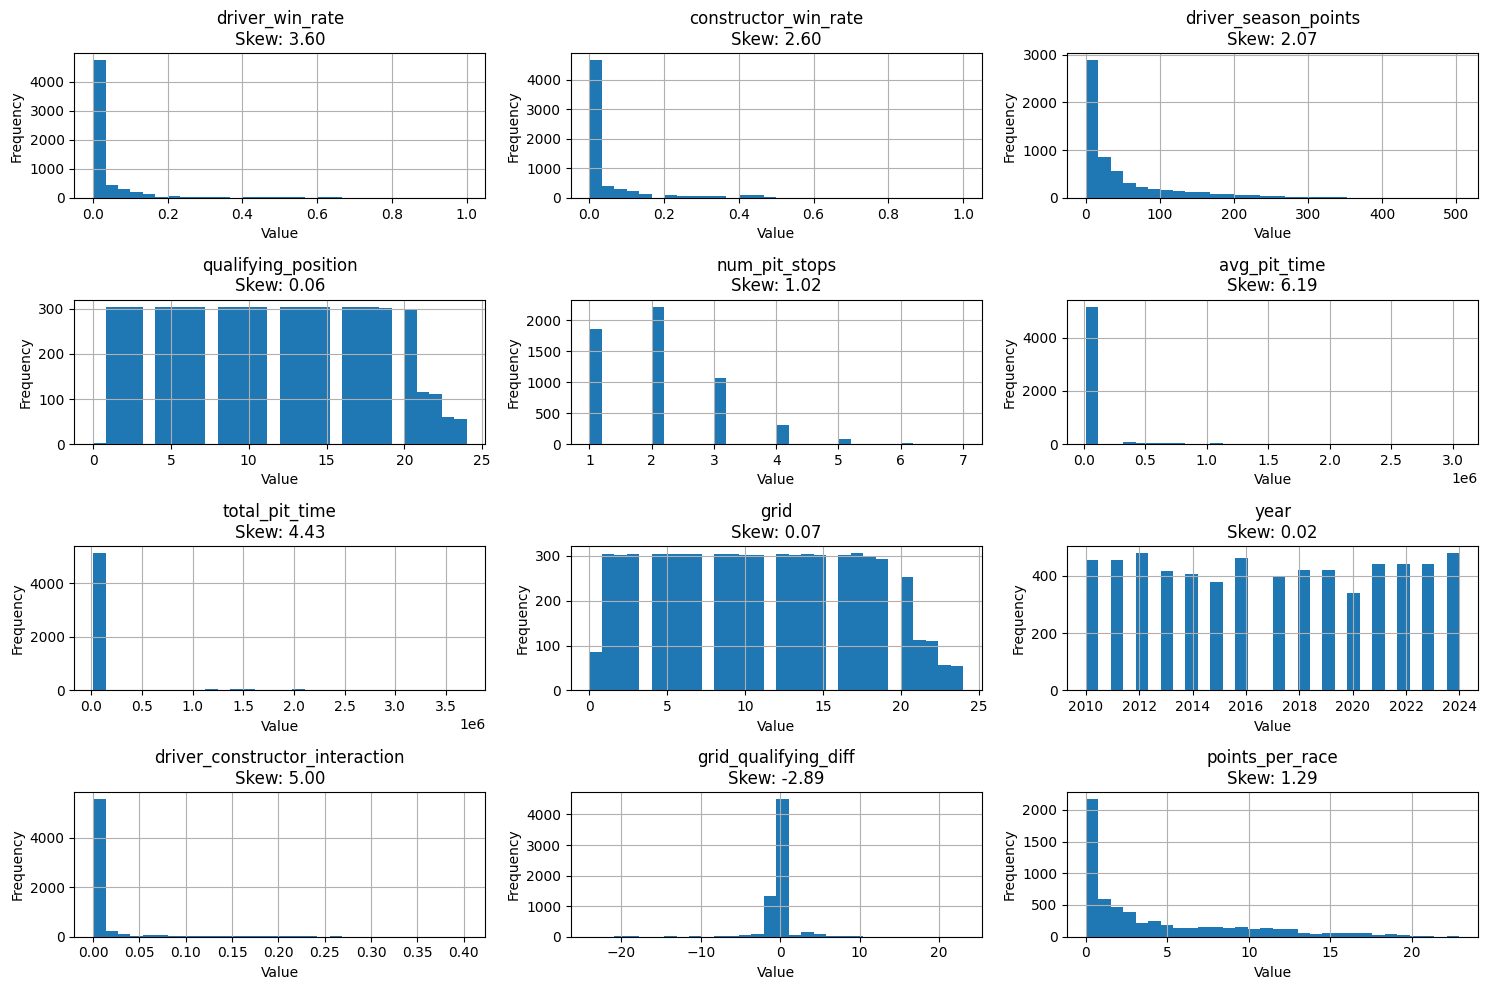

In [ ]:
# Plot distributions to determine scaling needs
fig, axes = plt.subplots(4, 3, figsize=(15, 10))
axes = axes.ravel()

print("Distributions of features:")

for i, col in enumerate(feature_columns):
    if i < len(axes):
        ml_data[col].hist(bins=30, ax=axes[i])
        axes[i].set_title(f"{col}\nSkew: {ml_data[col].skew():.2f}")
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Drop Low Impact features

Remove features that have no meaningful contribution to outcome

1. Based on feedback from model coefficients after initial training of them model, we determine that below features have no meaningful impact to outcomes.
    - `avg_pit_time`
    - `total_pit_time`, 
    - `driver_season_points`, 
    - `grid_qualifying_diff` 
2. Remove these features from dataset.

In [ ]:
# Remove low impact features
low_impact_features = [
    "avg_pit_time",
    "total_pit_time",
    "driver_season_points",
    "grid_qualifying_diff",
]
feature_columns = [f for f in feature_columns if f not in low_impact_features]

print("Dropping low impact features...")
print("Low Impact Features:", low_impact_features)
print("Features:", feature_columns)


Dropping low impact features...
Low Impact Features: ['avg_pit_time', 'total_pit_time', 'driver_season_points', 'grid_qualifying_diff']
Features: ['driver_win_rate', 'constructor_win_rate', 'qualifying_position', 'num_pit_stops', 'grid', 'year', 'driver_constructor_interaction', 'points_per_race', 'recent_avg_position', 'constructor_recent_wins']


In [ ]:
# Prepare features and target
X_train = train_val_data[feature_columns]
y_train = train_val_data["is_winner"]
X_test = test_data[feature_columns]
y_test = test_data["is_winner"]

# Check for missing values
print("")
print("Missing values per feature:")
print("Training:")
print(X_train[feature_columns].isnull().sum())

print("")
print("Test:")
print(X_test[feature_columns].isnull().sum())

print("")
print("Imputing features...")

simple_imputer = SimpleImputer(strategy="median")

X_train_imputed = pd.DataFrame(
    simple_imputer.fit_transform(X_train), columns=feature_columns, index=X_train.index
)

X_test_imputed = pd.DataFrame(
    simple_imputer.transform(X_test), columns=feature_columns, index=X_test.index
)


# Apply different scalers based on data characteristics
def apply_mixed_scaling(X_train, X_test, feature_columns):
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Define scaling strategy per column
    scaling_strategy = {
        "qualifying_position": MinMaxScaler(),
        "grid": MinMaxScaler(),
        "driver_win_rate": None,
        "constructor_win_rate": None,
        "driver_season_points": RobustScaler(),
        "year": StandardScaler(),
        "num_pit_stops": MinMaxScaler(),
        "avg_pit_time": RobustScaler(),
        "total_pit_time": RobustScaler(),
        "driver_constructor_interaction": None,
        "points_per_race": RobustScaler(),
        "recent_avg_position": RobustScaler(),
        "constructor_recent_wins": MinMaxScaler(),
    }

    scalers = {}
    for col in feature_columns:
        scaler = scaling_strategy.get(col, None)
        if scaler is not None:
            X_train_scaled[col] = scaler.fit_transform(X_train[[col]])
            X_test_scaled[col] = scaler.transform(X_test[[col]])
            scalers[col] = scaler

    return X_train_scaled, X_test_scaled, scalers, feature_columns


# Apply mixed scaling
print("Applying mixed scaling strategy...")
X_train_scaled, X_test_scaled, *rest = apply_mixed_scaling(
    X_train_imputed, X_test_imputed, feature_columns
)
scalars, feature_columns = rest

print("Features scaled successfully.")



Missing values per feature:
Training:
driver_win_rate                    69
constructor_win_rate               20
qualifying_position                 0
num_pit_stops                     743
grid                                0
year                                0
driver_constructor_interaction     75
points_per_race                   261
recent_avg_position                35
constructor_recent_wins             0
dtype: int64

Test:
driver_win_rate                    11
constructor_win_rate                3
qualifying_position                 0
num_pit_stops                     118
grid                                0
year                                0
driver_constructor_interaction     14
points_per_race                    89
recent_avg_position                 2
constructor_recent_wins             0
dtype: int64

Imputing features...
Applying mixed scaling strategy...
Features scaled successfully.


## Save Processed Data

In [ ]:
# Save processed data as parquet
print("Saving processed data...")

# Saving a copy
X_train_final = X_train_scaled.copy()
X_test_final = X_test_scaled.copy()

pd.DataFrame(X_train_final, columns=feature_columns).to_parquet(
    "../data/processed/X_train.parquet"
)
pd.DataFrame(X_test_final, columns=feature_columns).to_parquet(
    "../data/processed/X_test.parquet"
)
pd.DataFrame(y_train).to_parquet("../data/processed/y_train.parquet")
pd.DataFrame(y_test).to_parquet("../data/processed/y_test.parquet")

print("Saving features and samples...")

# Save feature names and scaler
metadata = {
    "feature_names": feature_columns,
    "train_samples": len(X_train_final),
    "test_samples": len(X_train_final),
}

with open("../data/processed/metadata.json", "w") as f:
    json.dump(metadata, f)

with open("../data/processed/scalers.pkl", "wb") as f:
    pickle.dump(scalars, f)

# Save test data with identifiers for analysis
test_data.to_csv("../data/processed/test_data_with_ids.csv", index=False)

print("Data saved successfully!")

print("")
print("Data Summary:")
print(f"Training samples: {len(X_train_final)}")
print(f"Test samples: {len(X_train_final)}")
print(f"Features: {len(feature_columns)}")

print(f"Winners in training: {y_train.sum()} ({y_train.mean():.3f})")
print(f"Winners in test: {y_test.sum()} ({y_test.mean():.3f})")

Saving processed data...
Saving features and samples...
Data saved successfully!

Data Summary:
Training samples: 4637
Test samples: 4637
Features: 10
Winners in training: 215 (0.046)
Winners in test: 90 (0.050)
